# Homework 2
**Instructions:**
- Submit your code to github by the deadline.
- DO NOT change paths (-3 points).
- DO NOT submit data to github (-2 points).

In [1]:
import numpy as np
import pandas as pd

## Problem 1: log loss
**(a)** You have a classification problem with 3 classes: "cat", "dog", "bird". For your test observation is a "dog". Your model give you the following prediction for that observation (0.1, 0.5, 0.4). What is the accuracy? What is the log loss?

**(b)** Suppose that you are submitting to a Kaggle competition. You are solving a binary classification task being evaluated by log loss metric. You suspect train and test target distributions are different, you submit a constant predition of 0.3 and to the public LB and get a score of 1.01. Mean of target variable in train is 0.44. What is the mean of target variable in public part of test data? Explain how you derive the results.

In [2]:
# YOUR CODE HERE
# YOUR CODE HERE
prediction = [0.1, 0.5, 0.4]
actual = [0, 1, 0]
if np.argmax(prediction) == np.argmax(actual): print('Accuracy = 1')      
print('Log Loss = ' + str(-np.log(prediction[np.argmax(actual)])))
    
      
#raise NotImplementedError()
#raise NotImplementedError()

Accuracy = 1
Log Loss = 0.6931471805599453


YOUR ANSWER HERE

Here, we know that log loss is 1.01 and p = 0.3. Thus, 

$ 1.01 = y * \log(p) + (1 - y)*\log(1-0.3) $

Solving this, we get $y$ which is the probability of the negative class. So we get the mean as $1 - y$.

In [3]:
# YOUR CODE HERE
y = -(1.01 + np.log(0.7))/np.log(0.3/0.7)
y # Probability of negative class
print('Mean target = ' + str(1-y))
#raise NotImplementedError()

Mean target = 0.22893106827543863


## Problem 2: AUC
Compute AUC score by hand with the formula explained in class for the following dataset.

In [4]:
d = pd.DataFrame({
        'prediction': [0.1, 0.5, 0.95, 0.99, 0.8, 0.4, 0.03, 0.44, 0.2],
        'y': [1, 0, 1, 1, 1, 1, 0, 0, 0]})
d

,prediction,y
0,0.10,1
1,0.50,0
2,0.95,1
3,0.99,1
4,0.80,1
5,0.40,1
6,0.03,0
7,0.44,0
8,0.20,0


AUC is the probability a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example. It can be computed as the ratio of

$$1 - \frac{\text{number of pairs example wrongly ordered }}{\text{number of pairs (positive, negative)}}$$

In [5]:
# YOUR CODE HERE
# YOUR CODE HERE
total = sum(d['y'] == 0) * sum(d['y'] == 1)
d = d.sort_values(['prediction'])
wrong = 0
for i in range(d.shape[0] - 1):
    if d.loc[i]['y'] > d.loc[i+1]['y']:
        wrong = wrong + 1
auc = 1 - (wrong/total)
print(auc)
#raise NotImplementedError()

0.9


## Problem 3: Regularized mean (target) encoding for Avazu competition

For this problem you will implement a version of regularized mean encoding. We will be using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [6]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [7]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding 
Here is how you do mean encoding without regularization.

In [8]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [9]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [10]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [11]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [12]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.0530389229998215


To do mean encoding with K-fold regularization you do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [13]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    col_name = col + '_mean_enc'
    kf = KFold(n_splits = splits, shuffle = False, random_state = 2)
    s = kf.split(train)
    for i in range(splits):
        train_index, test_index = next(s)
        mean_device_type = train.loc[train_index].groupby(col).click.mean()
        train.loc[test_index,col_name] = train[col].map(mean_device_type)
    global_mean = train.click.mean()
    train[col_name].fillna(global_mean, inplace=True)
    #raise NotImplementedError()

In [14]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]
assert(np.around(corr, decimals=4) == 0.0551)

In [15]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    col_name = col + '_mean_enc'
    mean_device_type = train.groupby(col).click.mean()
    global_mean = train.click.mean()
    test[col_name] = test[col].map(mean_device_type)
    test[col_name].fillna(global_mean, inplace=True)


    #raise NotImplementedError()

In [16]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()
assert(np.around(encoded_feature_mean, decimals=4) == 0.177)

## Problem 4: Implement other features and fit a model (10 points)
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

In [17]:
%matplotlib inline
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

In [18]:
plt.rcParams['figure.figsize'] = [13, 5]
plt.rcParams['agg.path.chunksize'] = 10000

### Load train and test files

In [19]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [20]:
# data, test = load_data()
path = "avazu/"
types = {'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
test_types = { 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
data = pd.read_csv(path + "train", usecols=types.keys(), dtype=types)
test = pd.read_csv(path + 'test', usecols=test_types.keys(), dtype=test_types)
# print(data.info(memory_usage=True))
# print(test.info(memory_usage=True))
data.info(memory_usage = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 23 columns):
click               uint8
hour                uint32
C1                  uint32
banner_pos          uint32
site_id             category
site_domain         category
site_category       category
app_id              category
app_domain          category
app_category        category
device_id           category
device_ip           category
device_model        category
device_type         uint8
device_conn_type    uint8
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: category(9), uint16(8), uint32(3), uint8(3)
memory usage: 2.4 GB


### Convert object to categorical

In [21]:
cols = data.select_dtypes('category').columns
cols

Index(['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_id', 'device_ip', 'device_model'],
      dtype='object')

In [22]:
def train_cats(cols, df):
    for col in cols:
        df[col] = df[col].astype('category').cat.as_ordered()

def apply_cats(cols, train, test):
    for col in cols:
            test[col] = pd.Categorical(test[col], categories=train[col].cat.categories, ordered=True)

def convert_codes(df, cols):
    for col in cols:
        df[col] = df[col].cat.codes+1            

In [23]:
train_cats(cols, data)
apply_cats(cols, data, test)
convert_codes(data, cols)
convert_codes(test, cols)

### Create date related features

In [24]:
def create_date_features(data):
    data['hour'] = pd.to_datetime(data['hour'], format='%y%m%d%H')
    data['day_of_week'] = data['hour'].dt.weekday
    data['hour_of_day'] = data['hour'].dt.hour    

create_date_features(data)
create_date_features(test)

test.head()

# data.isnull().sum()
# data.info(memory_usage=True,verbose = False)

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C14,C15,C16,C17,C18,C19,C20,C21,day_of_week,hour_of_day
0,2014-10-31,1005,0,906,892,13,470,19,1,2045,...,8330,320,50,761,3,175,34539,23,4,0
1,2014-10-31,1005,0,69,489,3,470,19,1,2045,...,22676,320,50,2616,0,35,34547,51,4,0
2,2014-10-31,1005,0,69,489,3,470,19,1,2045,...,22676,320,50,2616,0,35,34547,51,4,0
3,2014-10-31,1005,0,309,395,6,160,27,3,2045,...,18648,320,50,1092,3,809,34620,61,4,0
4,2014-10-31,1005,0,309,395,6,303,6,15,2045,...,23160,320,50,2667,0,47,65535,221,4,0


### Splitting train into train and validation

In [25]:
train, val = split_based_hour(data)
del data
train = train.drop(['hour', 'index'], axis = 1)
val = val.drop(['hour', 'index'], axis = 1)
test = test.drop(['hour'], axis = 1)

In [26]:
train.shape, val.shape, test.shape

((32343173, 24), (8085794, 24), (4577464, 23))

### Target encoding of the train, validation and test sets

In [27]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    col_name = col + '_mean_enc'
    kf = KFold(n_splits = splits, shuffle = False, random_state = 2)
    s = kf.split(train)
    for i in range(splits):
        train_index, test_index = next(s)
        mean_device_type = train.loc[train_index].groupby(col).click.mean()
        train.loc[test_index,col_name] = train[col].map(mean_device_type)
    global_mean = train.click.mean()
    train[col_name].fillna(global_mean, inplace=True)
    train[col_name] = train[col_name].astype(np.float32)
    #raise NotImplementedError()

In [28]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    col_name = col + '_mean_enc'
    mean_device_type = train.groupby(col).click.mean()
    global_mean = train.click.mean()
    test[col_name] = test[col].map(mean_device_type)
    test[col_name].fillna(global_mean, inplace=True)
    test[col_name] = test[col_name].astype(np.float32)

    #raise NotImplementedError()

In [29]:
enc_cols = train.columns[2:]
for col in enc_cols:
    print(col)
    reg_target_encoding(train, col)
    mean_encoding_test(test=val, train=train, col = col)
    mean_encoding_test(test=test, train=train, col = col)
# train.head()    

banner_pos
site_id
site_domain
site_category
app_id
app_domain
app_category
device_id
device_ip
device_model
device_type
device_conn_type
C14
C15
C16
C17
C18
C19
C20
C21
day_of_week
hour_of_day


### Plots and value_counts()

In [30]:
cats = []
for col in enc_cols:
    cats.append(len(train[col].value_counts()))
pd.Series(enc_cols, cats)    

7                banner_pos
4551                site_id
7297            site_domain
26            site_category
8094                 app_id
539              app_domain
36             app_category
2216415           device_id
5563626           device_ip
8036           device_model
5               device_type
4          device_conn_type
2252                    C14
8                       C15
9                       C16
372                     C17
4                       C18
63                      C19
172                     C20
52                      C21
7               day_of_week
24              hour_of_day
dtype: object

<Container object of 22 artists>

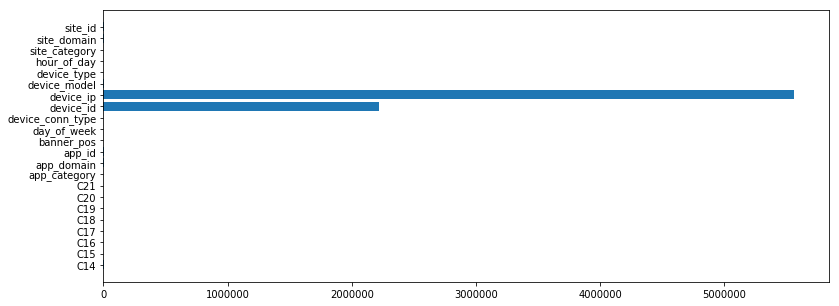

In [31]:
plt.barh(enc_cols, cats)

We can see that `device_ip` and `device_id` have too many levels. So we can remove their mean encoded columns.

In [32]:
train = train.drop(['device_ip_mean_enc', 'device_id_mean_enc'], axis = 1)
val = val.drop(['device_ip_mean_enc', 'device_id_mean_enc'], axis = 1)
test = test.drop(['device_ip_mean_enc', 'device_id_mean_enc'], axis = 1)

In [33]:
train.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C14_mean_enc,C15_mean_enc,C16_mean_enc,C17_mean_enc,C18_mean_enc,C19_mean_enc,C20_mean_enc,C21_mean_enc,day_of_week_mean_enc,hour_of_day_mean_enc
0,0,1005,0,69,489,3,470,19,1,2045,...,0.145022,0.1597,0.159448,0.188802,0.161420,0.177091,0.197646,0.188664,0.152223,0.184356
1,0,1010,1,309,395,6,500,19,3,2051,...,0.171469,0.1597,0.159448,0.171469,0.156287,0.177091,0.197646,0.271211,0.152223,0.184356
2,0,1005,0,69,489,3,470,19,1,2045,...,0.197214,0.1597,0.159448,0.188802,0.161420,0.177091,0.197646,0.188664,0.152223,0.184356
3,0,1005,1,309,395,6,423,6,3,2045,...,0.119682,0.1597,0.159448,0.119682,0.161420,0.119682,0.119892,0.107320,0.152223,0.184356
4,1,1005,0,336,351,5,470,19,1,2045,...,0.269599,0.1597,0.159448,0.269599,0.161420,0.248245,0.170657,0.271211,0.152223,0.184356


### Random forest

In [34]:
y_train = train['click']
X_train = train.drop(['click'], axis = 1)

y_val = val['click']
X_val = val.drop(['click'], axis = 1)

del train, val

In [35]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [36]:
from sklearn.ensemble import forest

In [37]:
set_rf_samples(400000)

### Baseline model

In [38]:
clf = RandomForestClassifier(random_state=10)

In [39]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [40]:
pred_train = clf.predict_proba(X_train)[:,1]
loss = log_loss(y_train, pred_train)
print('Training loss : ' + str(loss))

Training loss : 0.8798173968730889


In [41]:
pred_val = clf.predict_proba(X_val)[:,1]
loss = log_loss(y_val, pred_val)
print('Validation loss : ' + str(loss))

Validation loss : 0.7513659043519985


### Parameter tuning

In [46]:
clf = RandomForestClassifier(random_state=10, min_samples_leaf = 3, n_estimators = 40)

In [47]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [ ]:
pred_train = clf.predict_proba(X_train)[:,1]
loss = log_loss(y_train, pred_train)
print('Training loss : ' + str(loss))

In [ ]:
pred_val = clf.predict_proba(X_val)[:,1]
loss = log_loss(y_val, pred_val)
print('Validation loss : ' + str(loss))

In [ ]:
pred_test = clf.predict_proba(test)[:,1]
sub = pd.read_csv(path + 'sampleSubmission')
sub.click = pred_test
sub.to_csv('sub.csv', index=False)
sub.head()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()